## Metadata Integration

In [1]:
import os.path as osp
import pandas as pd
import numpy as np
%run env.py
%run src/lib.py

In [2]:
import hashlib
ID_TYP_CK = 'CK'
ID_TYP_TF = 'TF'
ID_TYP_CT = 'CT'

def get_ids(df, typ):
    ids = [':'.join([r['src'], str(r['spid']), r['sym'], r['lbl']]) for _, r in df.iterrows()]
    return [typ + hashlib.md5(v.encode('utf-8')).hexdigest()[:16].upper() for v in ids]

## Cytokines

#### Load from book table (Cameron and Kelvin)

From: https://www.ncbi.nlm.nih.gov/books/NBK6294/table/A13506/?report=objectonly

In [3]:
SRC = 'cameron'
dfr = pd.read_csv(osp.join(META_DATA_DIR, 'raw', 'cytokines.cameron.csv'), sep='\t')
dfr.head()

,name,synonym,amino,chromosome_acids,mwt,receptor_form,receptor_location
0,IL-1α,hematopoietin-1,271,2q14,30606,"CD121a, CDw121b","2q12, 2q12-q22"
1,IL-1β,catabolin,269,2q14,20747,"CD121a, CDw121b","2q12,2q12-q22"
2,IL-1RA,IL-1 receptor antagonist,177,2q14.2,20055,CD121a,2q12
3,IL-18,interferon-γ inducing factor,193,11q22.2-q22.3,22326,"IL-18Rα, β",2q12
4,IL-2,T cell growth factor,153,4q26-q27,17628,"CD25, 122,132","10p15-p14, 22q13.1, Xq13.1"


In [4]:
dft = (
    pd.concat([
        dfr[['name', 'name']].set_axis(['sym', 'lbl'], axis=1, inplace=False),
        dfr.set_index('name')['synonym'].str.split(',', expand=True).stack().str.strip()
            .reset_index().set_axis(['lbl', 'i', 'sym'], axis=1, inplace=False)
            .filter(items=['sym', 'lbl'])
    ])
    .assign(spid=SPECIES_HUMAN_ID, src=SRC)
)
dft.head()

,sym,lbl,spid,src
0,IL-1α,IL-1α,1,cameron
1,IL-1β,IL-1β,1,cameron
2,IL-1RA,IL-1RA,1,cameron
3,IL-18,IL-18,1,cameron
4,IL-2,IL-2,1,cameron


In [5]:
def transform(df, mask, fn):
    df = df.loc[mask.values].copy()
    df['sym'] = df['sym'].apply(fn)
    return df
df = dft.append(transform(dft, dft['sym'].str.match(r'IL-[^ ]+$|TNF-|IFN-|TGF-'), lambda v: v.replace('-', '')))
df['sym'] = df['sym'].str.strip()
df['lbl'] = df['lbl'].str.strip()
df = df[df['sym'].str.len() > 0]
df.head()

,sym,lbl,spid,src
0,IL-1α,IL-1α,1,cameron
1,IL-1β,IL-1β,1,cameron
2,IL-1RA,IL-1RA,1,cameron
3,IL-18,IL-18,1,cameron
4,IL-2,IL-2,1,cameron


In [6]:
df['sym'].unique()

array(['IL-1α', 'IL-1β', 'IL-1RA', 'IL-18', 'IL-2', 'IL-4', 'IL-7',
       'IL-9', 'IL-13', 'IL-15', 'IL-3', 'IL-5', 'GM-CSF', 'IL-6',
       'IL-11', 'G-CSF', 'IL-12', 'LIF', 'OSM', 'IL-10', 'IL-20', 'IL-14',
       'IL-16', 'IL-17', 'IFN-α', 'IFN-β', 'IFN-γ', 'CD154', 'LT-β',
       'TNF-α', 'TNF-β', '4-1BBL', 'APRIL', 'CD70', 'CD153', 'CD178',
       'GITRL', 'LIGHT', 'OX40L', 'TALL-1', 'TRAIL', 'TWEAK', 'TRANCE',
       'TGF-β1', 'TGF-β2', 'TGF-β3', 'hematopoietin-1', 'catabolin',
       'IL-1 receptor antagonist', 'interferon-γ inducing factor',
       'T cell growth factor', 'BSF-1', 'T cell growth factor P40',
       'P600', 'multipotential CSF', 'MCGF', 'BCDF-1', 'CSF-2', 'IFN-β2',
       'BSF-2', 'AGIF', 'CSF-3', 'NK cell stimulatory factor',
       'leukemia inhibitory factor', 'oncostatin M', 'CSIF', 'HMW-BCGF',
       'LCF', 'CTLA-8', 'CD40L', 'TRAP', 'cachectin', 'LT-α', 'TALL-2',
       'CD27L', 'CD30L', 'FasL', 'Apo2L', 'Apo3L', 'OPGL', 'TGF-β',
       'IL1α', 'IL1β', 'I

In [7]:
df['extid'] = None
df['id'] = get_ids(df, ID_TYP_CK)
df.head()

,sym,lbl,spid,src,extid,id
0,IL-1α,IL-1α,1,cameron,None,CK3618F8D5635EA31B
1,IL-1β,IL-1β,1,cameron,None,CKA07F01C879D8D6C2
2,IL-1RA,IL-1RA,1,cameron,None,CKA95B181F6273B58D
3,IL-18,IL-18,1,cameron,None,CKBF6003C60D23BA0D
4,IL-2,IL-2,1,cameron,None,CKD21834C7D75FD77F


In [8]:
df_cameron = df.copy()

#### Load from mygene

In [9]:
import mygene
SRC = 'mygene'
mg = mygene.MyGeneInfo()

In [10]:
df = mg.query(
    q='interleukin',
    size=1000,
    scopes=["symbol", "retired", "name", "alias"],
    fields='symbol,name,taxid,ensembl.gene,alias', 
    species='human', 
    as_dataframe=True
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 8 columns):
_id             570 non-null object
_score          570 non-null float64
alias           531 non-null object
ensembl         30 non-null object
ensembl.gene    522 non-null object
name            570 non-null object
symbol          570 non-null object
taxid           570 non-null int64
dtypes: float64(1), int64(1), object(6)
memory usage: 35.7+ KB


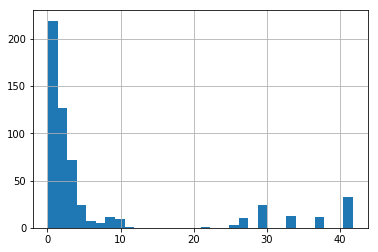

In [11]:
%matplotlib inline
df['_score'].hist(bins=32)

In [12]:
dft = df[df['_score'] > 20].copy()
dft = dft[dft['name'].str.match('interleukin \w+$')]
dft = dft.rename(columns={'_id': 'extid'}).drop('_score', axis=1)
dft.head()

,extid,alias,ensembl,ensembl.gene,name,symbol,taxid
0,53342,IL-17D,NaN,ENSG00000172458,interleukin 17D,IL17D,9606
1,3562,"[IL-3, MCGF, MULTI-CSF]",NaN,ENSG00000164399,interleukin 3,IL3,9606
2,3605,"[CTLA-8, CTLA8, IL-17, IL-17A, IL17]",NaN,ENSG00000112115,interleukin 17A,IL17A,9606
3,55801,"[AK155, IL-26]",NaN,ENSG00000111536,interleukin 26,IL26,9606
4,64806,IL17E,NaN,ENSG00000166090,interleukin 25,IL25,9606


In [13]:
dft['name'].unique()

array(['interleukin 17D', 'interleukin 3', 'interleukin 17A',
       'interleukin 26', 'interleukin 25', 'interleukin 27',
       'interleukin 20', 'interleukin 16', 'interleukin 33',
       'interleukin 7', 'interleukin 18', 'interleukin 17C',
       'interleukin 9', 'interleukin 34', 'interleukin 17F',
       'interleukin 17B', 'interleukin 15', 'interleukin 24',
       'interleukin 2', 'interleukin 31', 'interleukin 22',
       'interleukin 32', 'interleukin 12A', 'interleukin 19',
       'interleukin 11', 'interleukin 5', 'interleukin 6',
       'interleukin 10', 'interleukin 12B', 'interleukin 13',
       'interleukin 21', 'interleukin 37', 'interleukin 4'], dtype=object)

In [14]:
dfs = []
for i, r in dft.iterrows():
    dfs.append((r['name'], r['symbol'], r['extid']))
    dfs.append((r['symbol'], r['symbol'], r['extid']))
    aliases = [] 
    if r['alias'] is not None:
        aliases = [r['alias']] if isinstance(r['alias'], str) else r['alias']
    for alias in aliases:
        dfs.append((alias, r['symbol'], r['extid']))
dfs = pd.DataFrame(dfs, columns=['sym', 'lbl', 'extid'])
dfs = dfs.assign(spid=SPECIES_HUMAN_ID, src=SRC)
dfs['id'] = get_ids(dfs, ID_TYP_CK)
dfs.head()

,sym,lbl,extid,spid,src,id
0,interleukin 17D,IL17D,53342,1,mygene,CK935C505B6ED63720
1,IL17D,IL17D,53342,1,mygene,CKFB59E8DF35078E4F
2,IL-17D,IL17D,53342,1,mygene,CKD60BA9775658A4C0
3,interleukin 3,IL3,3562,1,mygene,CKD868366DC34743F4
4,IL3,IL3,3562,1,mygene,CKE1271585C8AC0459


In [15]:
# Check for (and remove) any excessively vague symbols
dfs['sym'].unique()

array(['interleukin 17D', 'IL17D', 'IL-17D', 'interleukin 3', 'IL3',
       'IL-3', 'MCGF', 'MULTI-CSF', 'interleukin 17A', 'IL17A', 'CTLA-8',
       'CTLA8', 'IL-17', 'IL-17A', 'IL17', 'interleukin 26', 'IL26',
       'AK155', 'IL-26', 'interleukin 25', 'IL25', 'IL17E',
       'interleukin 27', 'IL27', 'IL-27', 'IL-27A', 'IL27A', 'IL27p28',
       'IL30', 'p28', 'interleukin 20', 'IL20', 'IL-20', 'IL10D',
       'ZCYTO10', 'interleukin 16', 'IL16', 'LCF', 'NIL16', 'PRIL16',
       'prIL-16', 'interleukin 33', 'IL33', 'C9orf26', 'DVS27', 'IL1F11',
       'NF-HEV', 'NFEHEV', 'interleukin 7', 'IL7', 'IL-7',
       'interleukin 18', 'IL18', 'IGIF', 'IL-18', 'IL-1g', 'IL1F4',
       'interleukin 17C', 'IL17C', 'CX2', 'IL-17C', 'interleukin 9',
       'IL9', 'HP40', 'IL-9', 'P40', 'interleukin 34', 'IL34', 'C16orf77',
       'IL-34', 'interleukin 17F', 'IL17F', 'CANDF6', 'IL-17F', 'ML-1',
       'ML1', 'interleukin 17B', 'IL17B', 'IL-17B', 'NIRF', 'ZCYTO7',
       'interleukin 15', 'IL15', 

In [16]:
dfs[dfs['sym'].str.match('lymphokine')]

,sym,lbl,extid,spid,src,id
97,lymphokine,IL2,3558,1,mygene,CK9298120219D4DCFC


In [17]:
dfsf = dfs[~dfs['sym'].str.match('lymphokine')]
len(dfs), len(dfsf)

(200, 199)

In [18]:
df_mygene = dfsf.copy()

In [19]:
df_mygene[df_mygene['lbl'] == 'IL2']

,sym,lbl,extid,spid,src,id
93,interleukin 2,IL2,3558,1,mygene,CK9C8188807B0D83D6
94,IL2,IL2,3558,1,mygene,CKC3BECFC2416C80F7
95,IL-2,IL2,3558,1,mygene,CK8704C6CACEA5DE28
96,TCGF,IL2,3558,1,mygene,CK0AB2532CFC3AB164


#### Load Manual Entries

In [20]:
SRC = 'manual'
df = pd.read_csv(osp.join(META_DATA_DIR, 'raw', 'cytokines.manual.csv'), sep=',')
df = df.assign(src=SRC, extid=None)
df['id'] = get_ids(df, ID_TYP_CK)
df.head()

,sym,lbl,spid,src,extid,id
0,IL-23,IL-23,1,manual,None,CKBB5E75DBC75FF4F6
1,IL23,IL-23,1,manual,None,CK1ADD3CDC140B33EA


In [21]:
df_manual = df.copy()

#### Merge and Export

In [22]:
cols = ['id', 'src', 'sym', 'lbl', 'spid', 'extid']
df = pd.concat([df_cameron[cols], df_mygene[cols], df_manual[cols]])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 0 to 1
Data columns (total 6 columns):
id       312 non-null object
src      312 non-null object
sym      312 non-null object
lbl      312 non-null object
spid     312 non-null int64
extid    199 non-null object
dtypes: int64(1), object(5)
memory usage: 17.1+ KB
None


,id,src,sym,lbl,spid,extid
0,CK3618F8D5635EA31B,cameron,IL-1α,IL-1α,1,None
1,CKA07F01C879D8D6C2,cameron,IL-1β,IL-1β,1,None
2,CKA95B181F6273B58D,cameron,IL-1RA,IL-1RA,1,None
3,CKBF6003C60D23BA0D,cameron,IL-18,IL-18,1,None
4,CKD21834C7D75FD77F,cameron,IL-2,IL-2,1,None


In [34]:
df[df['sym'].str.match('TGF.$')]

,id,src,sym,lbl,spid,extid
46,CK8ADDB4814EC2BC7A,cameron,TGFβ,TGF-β1,1,None


In [23]:
path = osp.join(META_DATA_DIR, 'cytokines.csv')
df.to_csv(path, index=False)
path

'/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/meta/cytokines.csv'

## Transcription Factors

In [10]:
df = pd.DataFrame([
    ('T-bet', 'T-bet'),
    ('Gata3', 'Gata3'),
    ('FoxP3', 'FoxP3')
], columns=['sym', 'lbl'])
df = df.assign(species=SPECIES_HUMAN_ID, src_id=1)
df = df.assign(id=np.arange(1, len(df) + 1))
df

,sym,lbl,species,src_id,id
0,T-bet,T-bet,1,1,1
1,Gata3,Gata3,1,1,2
2,FoxP3,FoxP3,1,1,3


In [11]:
path = osp.join(META_DATA_DIR, 'transcription_factors.csv')
df.to_csv(path, index=False)
path

'/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/meta/transcription_factors.csv'

## Cell Types

In [179]:
SRC = 'manual'
cell_types = [
    ('TN', ['T-naïve', 'naïve-T']),
    ('TEMRA', ['T-emra', 'emra-T']),
    ('TCM', ['T-cm', 'cm-T']),
    ('TEFF', ['T-eff', 'T-effector', 'eff-T', 'effector-T']),
    ('TEM', ['T-em', 'em-T']),
    ('Th', ['T-Helper', 'Helper-T']),
    ('ThP', ['Th-Precursor', 'Precursor-Th']),
    ('Trm', ['T-rm', 'T-resident-memory', 'resident-memory-T']),
    ('Tscm', ['T-SCM']),
    ('NKT', ['natural-killer-T', 'T-natural-killer', 'INKT', 'TRNKT', 'CNKT', 'NK/T']),
    ('MAIT', ['Mucosal-associated invariant T']),
    ('Treg', ['T-reg', 'T-regs', 'T-regulatory', 'regulatory-T']),
    ('Tsupp', ['Tsuppressor', 'Ts/c', 'Ts/Tc','T-suppressor/cytotoxic'], 'Treg'),
    ('Treg1', ['T-reg1', 'Treg/Th1', 'TregTh1', 'Tr1'], 'Treg'),
    ('Treg17', ['T-reg17', 'Treg/Th17', 'TregTh17', 'Tr17'], 'Treg'),
    ('Tfh', ['T-FH', 'T-follicular-helper', 'fhT'], 'Th'),
    ('Tfreg', ['Tf-reg', 'T-follicular-regulatory', 'follicular-Treg', 'fTreg'], 'Treg'),
    ('iTreg', ['inducible-Treg', 'induced-Treg', 'inducible-regulatory-T'], 'Treg'),
    ('pTreg', ['peripheral-Treg'], 'Treg'),
    ('γδT', ['GammaDeltaT', 'TGammaDelta', 'Gamma/DeltaT', 'γ/δT', 'gdT', 'Tgd', 'g/dT', 'Tg/d']),
    ('γδT-Vδ1', ['VDelta1T', 'Vδ1T'], 'γδT'),
    ('γδT-Vδ2', ['VDelta2T', 'Vδ2T'], 'γδT'),
    ('γδT-Vγ9', ['VGamma9T', 'Vγ9T'], 'γδT'),
    ('γδT-Vγ9Vδ2', ['VGamma9Delta2T', 'Vγ9Vδ2T'], 'γδT'),
    ('γδT-17', ['γδ17T', 'TGammaDelta17'], 'γδT'),
    ('γδT-TCS1', ['TCS1'], 'γδT')
] + [
    ('Tc' + str(i), ['Tc-' + str(i), 'T-cytolitic-' + str(i), 'T-cytotoxic-' + str(i)]) 
    for i in [0, 1, 2, 3, 9, 17, 22]
] + [
    ('Th' + str(i), ['Th-' + str(i), 'T-helper-' + str(i)]) 
    for i in [0, 1, 2, 3, 9, 17, 22]
] + [
    ('Tfh{}like'.format(i), ['Tfh-{}-like'.format(i), 'Tfh-{}like'.format(i), 'Tfh{}-like'.format(i)]) 
    for i in [0, 1, 2, 3, 9, 17, 22]
]

In [180]:
import unidecode
df = []
for r in cell_types:
    assert len(r) in [2, 3]
    lbl, alias = r[:2]
    parent = None if len(r) == 2 else r[2]
    df.append((lbl, lbl))
    for a1 in alias:
        for a2 in [a1, unidecode.unidecode(a1)]:
            df.append((a2, lbl))
            df.append((a2.replace('-', ' '), lbl))
            df.append((a2.replace('-', ''), lbl))
df = pd.DataFrame(df, columns=['sym', 'lbl'])
df = df.assign(spid=SPECIES_HUMAN_ID, src=SRC, extid=None)
df['id'] = get_ids(df, ID_TYP_CT)
df = df.drop_duplicates()
df.head()

,sym,lbl,spid,src,extid,id
0,TN,TN,1,manual,None,CT591AB86BE24D7A57
1,T-naïve,TN,1,manual,None,CTE283259FDAF532CC
2,T naïve,TN,1,manual,None,CTC08BA13585D27DA5
3,Tnaïve,TN,1,manual,None,CTA34535F3D8CB4079
4,T-naive,TN,1,manual,None,CT6D35F4BB1D4D94BF


In [181]:
df[df['lbl'].str.match('Th\d')].head(15)

,sym,lbl,spid,src,extid,id
591,Th0,Th0,1,manual,None,CTBDDE0043F47EDCC1
592,Th-0,Th0,1,manual,None,CT9B8AEFDE61D40F75
593,Th 0,Th0,1,manual,None,CT04A2F5E4125FA594
598,T-helper-0,Th0,1,manual,None,CTBD1BDE561333FA0A
599,T helper 0,Th0,1,manual,None,CT550BD2F6E7C9F4A6
600,Thelper0,Th0,1,manual,None,CT2B7FD02233168156
604,Th1,Th1,1,manual,None,CTC3A8C3CBC245616A
605,Th-1,Th1,1,manual,None,CT1706049E8C1B882B
606,Th 1,Th1,1,manual,None,CTA7F9F663B53FB244
611,T-helper-1,Th1,1,manual,None,CT0E1FCE053B4D59AE


In [183]:
#df['sym'].unique()

In [184]:
path = osp.join(META_DATA_DIR, 'cell_types.csv')
df.to_csv(path, index=False)
path

'/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/meta/cell_types.csv'